## Day 25 Lecture 2 Assignment

In this assignment, we will extend a previous binary model to a multinomial case with three classes. We will use the FIFA soccer ratings dataset loaded below and analyze the model generated for this dataset.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import cross_val_score, cross_val_predict

%matplotlib inline

In [2]:
def remove_correlated_features(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in dataset.columns:
                    print(f'Deleted {colname} from dataset.')
                    del dataset[colname]

    return dataset

In [3]:
soccer_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/fifa_ratings.csv')

In [4]:
soccer_data.head()

,ID,Name,Overall,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,158023,L. Messi,94,84,95,70,90,86,97,93,...,94,48,22,94,94,75,96,33,28,26
1,20801,Cristiano Ronaldo,94,84,94,89,81,87,88,81,...,93,63,29,95,82,85,95,28,31,23
2,190871,Neymar Jr,92,79,87,62,84,84,96,88,...,82,56,36,89,87,81,94,27,24,33
3,192985,K. De Bruyne,91,93,82,55,92,82,86,85,...,91,76,61,87,94,79,88,68,58,51
4,183277,E. Hazard,91,81,84,61,89,80,95,83,...,80,54,41,87,89,86,91,34,27,22


Our response for our logistic regression model is going to be a new column, "RankingTier", that contains three categories:

- High: Overall score > 75
- Middle: Overall score between 65 and 75
- Low: Overall score < 65

In [5]:
# answer goes here
soccer_data['RankingTier'] = np.where((soccer_data['Overall'] >= 75), 'High', 
                                      (np.where((soccer_data['Overall'] < 75) & (soccer_data['Overall'] >= 65), 'Middle', 
                                                'Low')))

The next few steps until model training are the same as before: identify and remove highly correlated features, and split the data into a training set (80%) and a test set (20%).

In [6]:
# answer goes here
remove_correlated_features(soccer_data, 0.9)

X = soccer_data.drop(['ID', 'Name', 'Overall', 'RankingTier'], axis=1)
Y = soccer_data['RankingTier']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Deleted StandingTackle from dataset.
Deleted SlidingTackle from dataset.


Fit a multinomial logistic regression model using the statsmodels package and print out the coefficient summary. What is the "reference" tier chosen by the model? How do we interpret the coefficients - for example, how does the intepretation of the "Reactions" coefficient for RankingTier=Low differ from the "Reactions" coefficient for RankingTier=Middle?

In [7]:
# answer goes here
X_train_const = sm.add_constant(X_train)

sm_model = sm.MNLogit(Y_train, X_train_const).fit()
print(sm_model.summary())
print(sm_model.summary2())

Optimization terminated successfully.
         Current function value: 0.359610
         Iterations 10
                          MNLogit Regression Results                          
Dep. Variable:            RankingTier   No. Observations:                12897
Model:                        MNLogit   Df Residuals:                    12841
Method:                           MLE   Df Model:                           54
Date:                Fri, 16 Oct 2020   Pseudo R-squ.:                  0.6273
Time:                        13:59:05   Log-Likelihood:                -4637.9
converged:                       True   LL-Null:                       -12445.
Covariance Type:            nonrobust   LLR p-value:                     0.000
   RankingTier=Low       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 95.5645      1.963     48.687      0.000      91.717      99.412
Cros

To evaluate test error using cross-validation, we will switch back to scikit-learn. Estimate the test error of this multinomial logistic regression model using 10-fold CV.

Note: scikit-learn's LogisticRegression() function can handle both binary and multinomial regression, and it is automatically able to determine which is appropriate based on the y_train array that is passed. You should be able to reuse previous code with minimal changes required.

In [8]:
# cv_logloss = cross_val_score(logit, X_train, Y_train, cv=5, scoring='neg_log_loss')

# print(f'Avg Log Loss: {cv_logloss.mean():.4f}, STD: {cv_logloss.std():.4f},\n Log Losses = {cv_logloss}')

In [9]:
# answer goes here
logit = LogisticRegression(max_iter=10000)
cv = cross_val_score(logit, X_train, Y_train, cv=5)

print(f'Mean: {cv.mean():.4f}, STD: {cv.std():.4f},\n cv = {cv}')


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Mean: 0.8387, STD: 0.0048,
 cv = [0.83837209 0.84496124 0.83210547 0.84296239 0.83520744]


In [10]:
logit = LogisticRegression(max_iter=10000)
logit.fit(X_train, Y_train)

test_score = logit.score(X_test, Y_test)
train_score = logit.score(X_train, Y_train)

print('Score on training data: ', train_score)
print('Score on test data: ', test_score)

Score on training data:  0.8411258432193534
Score on test data:  0.8390697674418605


As we did in the previous exercise, train a multinomial logistic regression on the training data, make predictions on the 20% holdout test data, then:

- Determine the precision, recall, and F1-score of our model using a cutoff/threshold of 0.5 (hint: scikit-learn's *classification_report* function may be helpful)
- Plot or otherwise generate a confusion matrix
- Plot the ROC curve for our logistic regression model

Comment on the performance of the model.

In [11]:
# answer goes here
predictions = logit.predict(X_test)
report = classification_report(Y_test, predictions, labels=['Low', 'Middle', 'High'])
print(report)

              precision    recall  f1-score   support

         Low       0.85      0.83      0.84      1251
      Middle       0.83      0.86      0.84      1614
        High       0.86      0.77      0.81       360

    accuracy                           0.84      3225
   macro avg       0.85      0.82      0.83      3225
weighted avg       0.84      0.84      0.84      3225



In [12]:
conf_mat = confusion_matrix(Y_test, predictions, labels=['Low', 'Middle', 'High'])
conf_mat

array([[1044,  207,    0],
       [ 185, 1385,   44],
       [   0,   83,  277]])

In [13]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

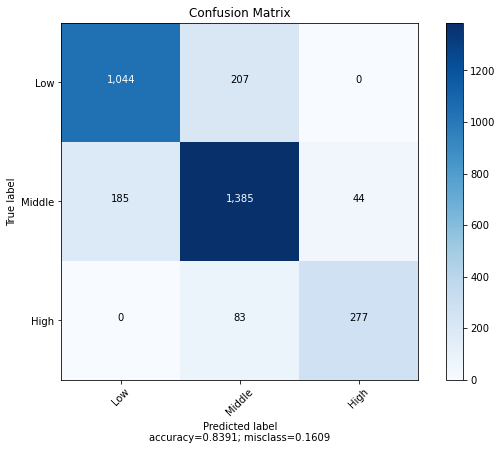

In [14]:
plot_confusion_matrix(cm=conf_mat, target_names = ['Low', 'Middle', 'High'], title = 'Confusion Matrix', normalize=False)

In [15]:
Y_bin = pd.get_dummies(Y_test)
Y_pred_prob = logit.predict_proba(X_test)
logit.classes_

array(['High', 'Low', 'Middle'], dtype=object)

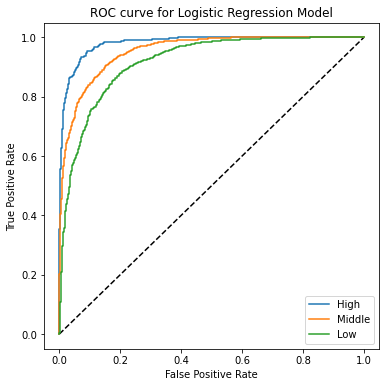

In [16]:
fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
fpr1, tpr1, thresholds = roc_curve(Y_bin['High'], Y_pred_prob[:,0])
line0, = plt.plot(fpr1, tpr1, label='High')

fpr2, tpr2, thresholds = roc_curve(Y_bin['Low'], Y_pred_prob[:,1])
line1, = plt.plot(fpr2, tpr2, label='Middle')

fpr3, tpr3, thresholds = roc_curve(Y_bin['Middle'], Y_pred_prob[:,2])
line2, = plt.plot(fpr3, tpr3, label='Low')

plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for Logistic Regression Model')
plt.show()